In [159]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import zscore
from scipy.stats import boxcox
import scipy.stats as stats
import torch
%matplotlib inline

In [160]:
idx = 26

In [161]:
import sys
sys.path.append("..") 
sys.path.append("../..") 
import torch
import numpy as np
import torch.nn.functional as F
import json

import hydra
from omegaconf import DictConfig
import paths

In [162]:
import seaborn as sns
sns.set() 
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
import paths

In [163]:
from models.unet_module import DownscalingUnetLightning 
from DownscalingDataModule import DownscalingDataModule

Dataloaders

In [164]:
# Define train and val input/target paths (update file paths as needed)
train_input_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_input_train_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_input_train_scaled.nc",
}
train_target_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_target_train_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_target_train_scaled.nc",

}
val_input_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_input_val_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_input_val_scaled.nc",

}
val_target_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_target_val_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_target_val_scaled.nc",

}

test_input_paths= {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_input_test_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_input_test_scaled.nc",

}

test_target_paths = {
    'precip': paths.DATASETS_TRAINING_DIR + "/RhiresD_target_test_scaled.nc",
    'temp': paths.DATASETS_TRAINING_DIR + "/TabsD_target_test_scaled.nc",

}


In [165]:
elevation_path = '/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/elevation.tif'

In [166]:
dm = DownscalingDataModule(
    train_input=train_input_paths,
    train_target=train_target_paths,
    val_input=val_input_paths,
    val_target=val_target_paths,
    test_input=test_input_paths,
    test_target=test_target_paths,
    elevation=elevation_path,
    batch_size=32,
    num_workers=4,
    preprocessing={
        'variables': {
            'input': {
                'precip': 'RhiresD',
                'temp': 'TabsD',

            },
            'target': {
                'precip': 'RhiresD',
                'temp': 'TabsD',

            }
        },
        'preprocessing': {
            'nan_to_num': True,
            'nan_value': 0.0
        }
    }
)
dm.setup()


In [167]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

In [168]:
train_inputs, train_targets = next(iter(train_loader))
val_inputs, val_targets = next(iter(val_loader))
test_inputs, test_targets = next(iter(test_loader))

1. Plotting Unet pred for idex = idx

In [169]:
ckpt_unet = paths.LDM_DIR+"/trained_ckpts_optimised/12km/LDM_conditional.models.unet_module.DownscalingUnetLightning_logtransform_lr0.01_precip_loss_weight5.0_1.0_crps[0, 1]_factor0.5_pat3.ckpt.ckpt"

In [170]:

model_UNet = DownscalingUnetLightning(
    in_ch=3,  # 4 vars + elevation
    out_ch=2,  # 4 output variables
    features=[64, 128, 256, 512],
    channel_names=["precip", "temp"],
    
)

In [171]:
unet_state_dict = torch.load(ckpt_unet, map_location="cpu",weights_only=False)["state_dict"]
model_UNet.load_state_dict(unet_state_dict, strict=False)
model_UNet.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (encoder): ModuleList()
    (decoder): ModuleList()
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2)

In [172]:
with open(paths.DATASETS_TRAINING_DIR + "/RhiresD_scaling_params.json", 'r') as f:
    pr_params = json.load(f)
with open(paths.DATASETS_TRAINING_DIR + "/TabsD_scaling_params.json", 'r') as f:
    temp_params = json.load(f)

def denorm_pr(x):

    return np.exp(x * pr_params['std'] + pr_params['mean']) - pr_params['epsilon']

def denorm_temp(x, params):

    return x * params['std'] + params['mean']

In [173]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [174]:
UNet_model = model_UNet.to(device)

#VAE encoding residuals 

In [175]:
unet_regr= DownscalingUnetLightning(in_ch=3,
                                    out_ch=2,
                                    features=[64, 128, 256, 512],
                                    channel_names=["precip", "temp"])

In [176]:
unet_regr_ckpt = torch.load("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/trained_ckpts_optimised/12km/LDM_conditional.models.unet_module.DownscalingUnetLightning_logtransform_lr0.01_precip_loss_weight5.0_1.0_crps[0, 1]_factor0.5_pat3.ckpt.ckpt",
                            map_location="cpu",
weights_only=False)["state_dict"]

In [177]:
unet_regr.load_state_dict(unet_regr_ckpt, strict=False) #Loading it second time for regression network inside VAE
unet_regr.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (encoder): ModuleList()
    (decoder): ModuleList()
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2)

Instantiating VAE

Loading LDM ckp

Inspecting ckps

In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_regr = DownscalingUnetLightning(
    in_ch=3,
    out_ch=2,
    features=[64, 128, 256, 512],
    channel_names=["precip", "temp"],
    precip_scaling_json=paths.DATASETS_TRAINING_DIR + "/RhiresD_scaling_params.json",
)
unet_regr_ckpt = torch.load(
    "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/trained_ckpts_optimised/12km/LDM_conditional.models.unet_module.DownscalingUnetLightning_logtransform_lr0.01_precip_loss_weight5.0_1.0_crps[0, 1]_factor0.5_pat3.ckpt.ckpt",
    map_location="cpu",weights_only=False
)["state_dict"]
unet_regr.load_state_dict(unet_regr_ckpt, strict=False)
unet_regr = unet_regr.to(device)
unet_regr.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (encoder): ModuleList()
    (decoder): ModuleList()
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2)

In [179]:
from models.components.diff.denoiser.unet import UNetModel
from models.components.diff.denoiser.ddim import DDIMSampler
from models.components.diff.conditioner import AFNOConditionerNetCascade
from models.diff_module import DDIMResidualContextual

In [ ]:
# Instantiate denoiser (pixel space, 2 channels, config-matched)
denoiser = UNetModel(
    model_channels=32,
    in_channels=2,
    out_channels=2,
    num_res_blocks=2,
    attention_resolutions=[1, 2, 4],
    context_ch=[32, 64, 128],
    channel_mult=[1, 2, 4],
    conv_resample=True,
    dims=2,
    use_fp16=False,
    num_heads=2
)

# Instantiate conditioner (no autoencoder, pixel context)
conditioner = AFNOConditionerNetCascade(
    autoencoder=None,
    input_channels=[2],
    embed_dim=[32, 64, 128],
    analysis_depth=3,
    cascade_depth=3,
    context_ch=[32, 64, 128]
)



ddim = DDIMResidualContextual(
    denoiser=denoiser,
    context_encoder=conditioner,
    timesteps=1000,
    parameterization="v",
    loss_type="l1"
)



ddim_ckpt = torch.load(
    "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/DDIM_conditional_derived/trained_ckpts/12km/DDIM_checkpoint_model.parameterization=0_model.timesteps=0_model.beta_schedule=0.ckpt",
    map_location=device
)


ddim.load_state_dict(ddim_ckpt["state_dict"], strict=False)
ddim = ddim.to(device)
ddim.eval()

normalization called with channels=32, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=64, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=64, norm_type=group, norm_kwargs={'num_groups': 8}
normalization called with channels=128, norm_type=group, norm_kwargs={'num_groups': 8}


DDIMResidualContextual(
  (denoiser): UNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=128, out_features=32, bias=True)
          )
          (out_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Dropout(p=0, inplace=False)
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )


In [181]:
sampler = DDIMSampler(ddim, device=device)

In [182]:
sampler

Data shape for DDIM sampling is (1, 2, 240, 370), eta 0.0
Running DDIM Sampling with 999 timesteps


DDIM Sampler:   0%|          | 1/999 [00:00<01:45,  9.44it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])

DDIM Sampler:   1%|          | 5/999 [00:00<01:05, 15.10it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: tor

DDIM Sampler:   1%|          | 9/999 [00:00<01:03, 15.69it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   1%|          | 11/999 [00:00<01:02, 15.81it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   2%|▏         | 15/999 [00:00<01:01, 15.93it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:   2%|▏         | 17/999 [00:01<01:01, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   2%|▏         | 19/999 [00:01<01:01, 15.95it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:   2%|▏         | 21/999 [00:01<01:01, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   3%|▎         | 25/999 [00:01<01:00, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   3%|▎         | 27/999 [00:01<01:00, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   3%|▎         | 29/999 [00:01<01:00, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:   3%|▎         | 31/999 [00:01<01:00, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   4%|▎         | 35/999 [00:02<01:00, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:   4%|▎         | 37/999 [00:02<01:00, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   4%|▍         | 39/999 [00:02<01:00, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:   4%|▍         | 41/999 [00:02<00:59, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   5%|▍         | 45/999 [00:02<00:59, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   5%|▍         | 47/999 [00:02<00:59, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   5%|▍         | 49/999 [00:03<00:59, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:   5%|▌         | 51/999 [00:03<00:59, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   6%|▌         | 55/999 [00:03<00:58, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:   6%|▌         | 57/999 [00:03<00:58, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   6%|▌         | 59/999 [00:03<00:58, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:   6%|▌         | 61/999 [00:03<00:58, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   7%|▋         | 65/999 [00:04<00:58, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   7%|▋         | 67/999 [00:04<00:58, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   7%|▋         | 69/999 [00:04<00:58, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:   7%|▋         | 71/999 [00:04<00:57, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   8%|▊         | 75/999 [00:04<00:57, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   8%|▊         | 77/999 [00:04<00:57, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   8%|▊         | 79/999 [00:04<00:57, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:   8%|▊         | 81/999 [00:05<00:57, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:   9%|▊         | 85/999 [00:05<00:57, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:   9%|▊         | 87/999 [00:05<00:56, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:   9%|▉         | 89/999 [00:05<00:56, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:   9%|▉         | 91/999 [00:05<00:56, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  10%|▉         | 95/999 [00:05<00:56, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  10%|▉         | 97/999 [00:06<00:56, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  10%|▉         | 99/999 [00:06<00:56, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  10%|█         | 101/999 [00:06<00:56, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  11%|█         | 105/999 [00:06<00:55, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  11%|█         | 107/999 [00:06<00:55, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  11%|█         | 109/999 [00:06<00:55, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  11%|█         | 111/999 [00:06<00:55, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  12%|█▏        | 115/999 [00:07<00:55, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  12%|█▏        | 117/999 [00:07<00:55, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  12%|█▏        | 119/999 [00:07<00:55, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  12%|█▏        | 121/999 [00:07<00:54, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  13%|█▎        | 125/999 [00:07<00:54, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  13%|█▎        | 127/999 [00:07<00:54, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  13%|█▎        | 129/999 [00:08<00:54, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  13%|█▎        | 131/999 [00:08<00:54, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  14%|█▎        | 135/999 [00:08<00:53, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  14%|█▎        | 137/999 [00:08<00:53, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  14%|█▍        | 139/999 [00:08<00:53, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  14%|█▍        | 141/999 [00:08<00:53, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  15%|█▍        | 145/999 [00:09<00:53, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  15%|█▍        | 147/999 [00:09<00:53, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  15%|█▍        | 149/999 [00:09<00:53, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  15%|█▌        | 151/999 [00:09<00:52, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  16%|█▌        | 155/999 [00:09<00:52, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  16%|█▌        | 157/999 [00:09<00:52, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  16%|█▌        | 159/999 [00:09<00:52, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  16%|█▌        | 161/999 [00:10<00:52, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  17%|█▋        | 165/999 [00:10<00:51, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  17%|█▋        | 167/999 [00:10<00:51, 16.05it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  17%|█▋        | 169/999 [00:10<00:51, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  17%|█▋        | 171/999 [00:10<00:51, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  18%|█▊        | 175/999 [00:10<00:51, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  18%|█▊        | 177/999 [00:11<00:51, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  18%|█▊        | 179/999 [00:11<00:51, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  18%|█▊        | 181/999 [00:11<00:51, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  19%|█▊        | 185/999 [00:11<00:50, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  19%|█▊        | 187/999 [00:11<00:50, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  19%|█▉        | 189/999 [00:11<00:50, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  19%|█▉        | 191/999 [00:11<00:50, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  20%|█▉        | 195/999 [00:12<00:50, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  20%|█▉        | 197/999 [00:12<00:50, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  20%|█▉        | 199/999 [00:12<00:49, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  20%|██        | 201/999 [00:12<00:49, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  21%|██        | 205/999 [00:12<00:49, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  21%|██        | 207/999 [00:12<00:49, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  21%|██        | 209/999 [00:13<00:49, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  21%|██        | 211/999 [00:13<00:49, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  22%|██▏       | 215/999 [00:13<00:48, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  22%|██▏       | 217/999 [00:13<00:48, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  22%|██▏       | 219/999 [00:13<00:48, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  22%|██▏       | 221/999 [00:13<00:48, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  23%|██▎       | 225/999 [00:14<00:48, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  23%|██▎       | 227/999 [00:14<00:48, 16.05it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  23%|██▎       | 229/999 [00:14<00:48, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  23%|██▎       | 231/999 [00:14<00:47, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  24%|██▎       | 235/999 [00:14<00:47, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  24%|██▎       | 237/999 [00:14<00:47, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  24%|██▍       | 239/999 [00:14<00:47, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  24%|██▍       | 241/999 [00:15<00:47, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  25%|██▍       | 245/999 [00:15<00:47, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  25%|██▍       | 247/999 [00:15<00:46, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  25%|██▍       | 249/999 [00:15<00:46, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  25%|██▌       | 251/999 [00:15<00:46, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  26%|██▌       | 255/999 [00:15<00:46, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  26%|██▌       | 257/999 [00:16<00:46, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  26%|██▌       | 259/999 [00:16<00:46, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  26%|██▌       | 261/999 [00:16<00:46, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  27%|██▋       | 265/999 [00:16<00:45, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  27%|██▋       | 267/999 [00:16<00:45, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  27%|██▋       | 269/999 [00:16<00:45, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  27%|██▋       | 271/999 [00:16<00:45, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  28%|██▊       | 275/999 [00:17<00:45, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  28%|██▊       | 277/999 [00:17<00:45, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  28%|██▊       | 279/999 [00:17<00:45, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  28%|██▊       | 281/999 [00:17<00:44, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  29%|██▊       | 285/999 [00:17<00:44, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  29%|██▊       | 287/999 [00:17<00:44, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  29%|██▉       | 289/999 [00:18<00:44, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  29%|██▉       | 291/999 [00:18<00:44, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  30%|██▉       | 295/999 [00:18<00:43, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  30%|██▉       | 297/999 [00:18<00:43, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  30%|██▉       | 299/999 [00:18<00:43, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  30%|███       | 301/999 [00:18<00:43, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  31%|███       | 305/999 [00:19<00:43, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  31%|███       | 307/999 [00:19<00:43, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  31%|███       | 309/999 [00:19<00:43, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  31%|███       | 311/999 [00:19<00:42, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  32%|███▏      | 315/999 [00:19<00:42, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  32%|███▏      | 317/999 [00:19<00:42, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  32%|███▏      | 319/999 [00:19<00:42, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  32%|███▏      | 321/999 [00:20<00:42, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  33%|███▎      | 325/999 [00:20<00:42, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  33%|███▎      | 327/999 [00:20<00:41, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  33%|███▎      | 329/999 [00:20<00:41, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  33%|███▎      | 331/999 [00:20<00:41, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  34%|███▎      | 335/999 [00:20<00:41, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  34%|███▎      | 337/999 [00:21<00:41, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  34%|███▍      | 339/999 [00:21<00:41, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  34%|███▍      | 341/999 [00:21<00:41, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  35%|███▍      | 345/999 [00:21<00:40, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  35%|███▍      | 347/999 [00:21<00:40, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  35%|███▍      | 349/999 [00:21<00:40, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  35%|███▌      | 351/999 [00:21<00:40, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  36%|███▌      | 355/999 [00:22<00:40, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  36%|███▌      | 357/999 [00:22<00:40, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  36%|███▌      | 359/999 [00:22<00:39, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  36%|███▌      | 361/999 [00:22<00:39, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  37%|███▋      | 365/999 [00:22<00:39, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  37%|███▋      | 367/999 [00:22<00:39, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  37%|███▋      | 369/999 [00:23<00:39, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  37%|███▋      | 371/999 [00:23<00:39, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  38%|███▊      | 375/999 [00:23<00:38, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  38%|███▊      | 377/999 [00:23<00:38, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  38%|███▊      | 379/999 [00:23<00:38, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  38%|███▊      | 381/999 [00:23<00:38, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  39%|███▊      | 385/999 [00:24<00:38, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  39%|███▊      | 387/999 [00:24<00:38, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  39%|███▉      | 389/999 [00:24<00:38, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  39%|███▉      | 391/999 [00:24<00:37, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  40%|███▉      | 395/999 [00:24<00:37, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  40%|███▉      | 397/999 [00:24<00:37, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  40%|███▉      | 399/999 [00:24<00:37, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  40%|████      | 401/999 [00:25<00:37, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  41%|████      | 405/999 [00:25<00:37, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  41%|████      | 407/999 [00:25<00:36, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  41%|████      | 409/999 [00:25<00:36, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  41%|████      | 411/999 [00:25<00:36, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  42%|████▏     | 415/999 [00:25<00:36, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  42%|████▏     | 417/999 [00:26<00:36, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  42%|████▏     | 419/999 [00:26<00:36, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  42%|████▏     | 421/999 [00:26<00:36, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  43%|████▎     | 425/999 [00:26<00:35, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  43%|████▎     | 427/999 [00:26<00:35, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  43%|████▎     | 429/999 [00:26<00:35, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  43%|████▎     | 431/999 [00:26<00:35, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  44%|████▎     | 435/999 [00:27<00:35, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  44%|████▎     | 437/999 [00:27<00:35, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  44%|████▍     | 439/999 [00:27<00:35, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  44%|████▍     | 441/999 [00:27<00:34, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  45%|████▍     | 445/999 [00:27<00:34, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  45%|████▍     | 447/999 [00:27<00:34, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  45%|████▍     | 449/999 [00:28<00:34, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  45%|████▌     | 451/999 [00:28<00:34, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  46%|████▌     | 455/999 [00:28<00:34, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  46%|████▌     | 457/999 [00:28<00:33, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  46%|████▌     | 459/999 [00:28<00:33, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  46%|████▌     | 461/999 [00:28<00:33, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  47%|████▋     | 465/999 [00:29<00:33, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  47%|████▋     | 467/999 [00:29<00:33, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  47%|████▋     | 469/999 [00:29<00:33, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  47%|████▋     | 471/999 [00:29<00:32, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  48%|████▊     | 475/999 [00:29<00:32, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  48%|████▊     | 477/999 [00:29<00:32, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  48%|████▊     | 479/999 [00:29<00:32, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  48%|████▊     | 481/999 [00:30<00:32, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  49%|████▊     | 485/999 [00:30<00:32, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  49%|████▊     | 487/999 [00:30<00:31, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  49%|████▉     | 489/999 [00:30<00:31, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  49%|████▉     | 491/999 [00:30<00:31, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  50%|████▉     | 495/999 [00:30<00:31, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  50%|████▉     | 497/999 [00:31<00:31, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  50%|████▉     | 499/999 [00:31<00:31, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  50%|█████     | 501/999 [00:31<00:31, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  51%|█████     | 505/999 [00:31<00:30, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  51%|█████     | 507/999 [00:31<00:30, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  51%|█████     | 509/999 [00:31<00:30, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  51%|█████     | 511/999 [00:31<00:30, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  52%|█████▏    | 515/999 [00:32<00:30, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  52%|█████▏    | 517/999 [00:32<00:30, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  52%|█████▏    | 519/999 [00:32<00:30, 15.86it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  52%|█████▏    | 521/999 [00:32<00:29, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  53%|█████▎    | 525/999 [00:32<00:29, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  53%|█████▎    | 527/999 [00:32<00:29, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  53%|█████▎    | 529/999 [00:33<00:29, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  53%|█████▎    | 531/999 [00:33<00:29, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  54%|█████▎    | 535/999 [00:33<00:29, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  54%|█████▍    | 537/999 [00:33<00:28, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  54%|█████▍    | 539/999 [00:33<00:28, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  54%|█████▍    | 541/999 [00:33<00:28, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  55%|█████▍    | 545/999 [00:34<00:28, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  55%|█████▍    | 547/999 [00:34<00:28, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  55%|█████▍    | 549/999 [00:34<00:28, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  55%|█████▌    | 551/999 [00:34<00:27, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  56%|█████▌    | 555/999 [00:34<00:27, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  56%|█████▌    | 557/999 [00:34<00:27, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  56%|█████▌    | 559/999 [00:34<00:27, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  56%|█████▌    | 561/999 [00:35<00:27, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  57%|█████▋    | 565/999 [00:35<00:27, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  57%|█████▋    | 567/999 [00:35<00:27, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  57%|█████▋    | 569/999 [00:35<00:26, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  57%|█████▋    | 571/999 [00:35<00:26, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  58%|█████▊    | 575/999 [00:35<00:26, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  58%|█████▊    | 577/999 [00:36<00:26, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  58%|█████▊    | 579/999 [00:36<00:26, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  58%|█████▊    | 581/999 [00:36<00:26, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  59%|█████▊    | 585/999 [00:36<00:25, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  59%|█████▉    | 587/999 [00:36<00:25, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  59%|█████▉    | 589/999 [00:36<00:25, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  59%|█████▉    | 591/999 [00:36<00:25, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  60%|█████▉    | 595/999 [00:37<00:25, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  60%|█████▉    | 597/999 [00:37<00:25, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  60%|█████▉    | 599/999 [00:37<00:24, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  60%|██████    | 601/999 [00:37<00:24, 16.05it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  61%|██████    | 605/999 [00:37<00:24, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  61%|██████    | 607/999 [00:37<00:24, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  61%|██████    | 609/999 [00:38<00:24, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])


DDIM Sampler:  61%|██████    | 611/999 [00:38<00:24, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  62%|██████▏   | 615/999 [00:38<00:24, 15.94it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  62%|██████▏   | 619/999 [00:38<00:23, 15.93it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  62%|██████▏   | 621/999 [00:38<00:23, 15.90it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  63%|██████▎   | 625/999 [00:39<00:23, 15.92it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: tor

DDIM Sampler:  63%|██████▎   | 627/999 [00:39<00:23, 15.89it/s]

AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 

DDIM Sampler:  63%|██████▎   | 629/999 [00:39<00:23, 15.84it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])


DDIM Sampler:  63%|██████▎   | 631/999 [00:39<00:23, 15.92it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])

DDIM Sampler:  64%|██████▎   | 635/999 [00:39<00:23, 15.24it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  64%|██████▍   | 637/999 [00:39<00:23, 15.63it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.

DDIM Sampler:  64%|██████▍   | 641/999 [00:40<00:22, 15.82it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner c

DDIM Sampler:  65%|██████▍   | 645/999 [00:40<00:22, 15.94it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32]

DDIM Sampler:  65%|██████▍   | 647/999 [00:40<00:22, 15.95it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  65%|██████▌   | 651/999 [00:40<00:21, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  66%|██████▌   | 655/999 [00:40<00:21, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  66%|██████▌   | 657/999 [00:41<00:21, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  66%|██████▌   | 661/999 [00:41<00:21, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  67%|██████▋   | 665/999 [00:41<00:20, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  67%|██████▋   | 667/999 [00:41<00:20, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  67%|██████▋   | 671/999 [00:41<00:20, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  68%|██████▊   | 675/999 [00:42<00:20, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  68%|██████▊   | 677/999 [00:42<00:20, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  68%|██████▊   | 681/999 [00:42<00:19, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  69%|██████▊   | 685/999 [00:42<00:19, 15.95it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  69%|██████▉   | 687/999 [00:42<00:19, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  69%|██████▉   | 691/999 [00:43<00:19, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  70%|██████▉   | 695/999 [00:43<00:19, 15.97it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  70%|██████▉   | 697/999 [00:43<00:18, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  70%|███████   | 701/999 [00:43<00:18, 15.93it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  71%|███████   | 705/999 [00:44<00:18, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  71%|███████   | 707/999 [00:44<00:18, 15.99it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])

DDIM Sampler:  71%|███████   | 711/999 [00:44<00:17, 16.05it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  71%|███████▏  | 713/999 [00:44<00:17, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  72%|███████▏  | 717/999 [00:44<00:17, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  72%|███████▏  | 721/999 [00:45<00:17, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  72%|███████▏  | 723/999 [00:45<00:17, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  73%|███████▎  | 727/999 [00:45<00:16, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  73%|███████▎  | 731/999 [00:45<00:16, 16.05it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  73%|███████▎  | 733/999 [00:45<00:16, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  74%|███████▍  | 737/999 [00:46<00:17, 15.21it/s]

AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32]

DDIM Sampler:  74%|███████▍  | 739/999 [00:46<00:16, 15.60it/s]

AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32]

DDIM Sampler:  74%|███████▍  | 743/999 [00:46<00:16, 15.24it/s]

Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])

DDIM Sampler:  75%|███████▍  | 747/999 [00:46<00:16, 15.62it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  75%|███████▍  | 749/999 [00:46<00:15, 15.73it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  75%|███████▌  | 753/999 [00:47<00:15, 15.87it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  76%|███████▌  | 757/999 [00:47<00:15, 15.95it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  76%|███████▌  | 759/999 [00:47<00:15, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  76%|███████▋  | 763/999 [00:47<00:14, 15.90it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  77%|███████▋  | 767/999 [00:48<00:14, 16.06it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  77%|███████▋  | 769/999 [00:48<00:14, 16.05it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  77%|███████▋  | 773/999 [00:48<00:14, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  78%|███████▊  | 777/999 [00:48<00:13, 16.05it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  78%|███████▊  | 779/999 [00:48<00:13, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  78%|███████▊  | 783/999 [00:49<00:13, 16.05it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  79%|███████▉  | 787/999 [00:49<00:13, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  79%|███████▉  | 789/999 [00:49<00:13, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  79%|███████▉  | 793/999 [00:49<00:12, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  80%|███████▉  | 797/999 [00:49<00:12, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  80%|███████▉  | 799/999 [00:50<00:12, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  80%|████████  | 803/999 [00:50<00:12, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  81%|████████  | 807/999 [00:50<00:11, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  81%|████████  | 809/999 [00:50<00:11, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  81%|████████▏ | 813/999 [00:50<00:11, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  82%|████████▏ | 817/999 [00:51<00:11, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  82%|████████▏ | 819/999 [00:51<00:11, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  82%|████████▏ | 823/999 [00:51<00:10, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  83%|████████▎ | 827/999 [00:51<00:10, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  83%|████████▎ | 829/999 [00:51<00:10, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  83%|████████▎ | 833/999 [00:52<00:10, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  84%|████████▍ | 837/999 [00:52<00:10, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  84%|████████▍ | 839/999 [00:52<00:09, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  84%|████████▍ | 843/999 [00:52<00:09, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  85%|████████▍ | 847/999 [00:53<00:09, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  85%|████████▍ | 849/999 [00:53<00:09, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  85%|████████▌ | 853/999 [00:53<00:09, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  86%|████████▌ | 857/999 [00:53<00:08, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  86%|████████▌ | 859/999 [00:53<00:08, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  86%|████████▋ | 863/999 [00:53<00:08, 16.05it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  87%|████████▋ | 867/999 [00:54<00:08, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  87%|████████▋ | 869/999 [00:54<00:08, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  87%|████████▋ | 873/999 [00:54<00:07, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  88%|████████▊ | 877/999 [00:54<00:07, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  88%|████████▊ | 879/999 [00:55<00:07, 15.92it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  88%|████████▊ | 883/999 [00:55<00:07, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  89%|████████▉ | 887/999 [00:55<00:06, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  89%|████████▉ | 889/999 [00:55<00:06, 15.98it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  89%|████████▉ | 893/999 [00:55<00:06, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  90%|████████▉ | 897/999 [00:56<00:06, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  90%|████████▉ | 899/999 [00:56<00:06, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  90%|█████████ | 903/999 [00:56<00:05, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  91%|█████████ | 907/999 [00:56<00:05, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  91%|█████████ | 909/999 [00:56<00:05, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  91%|█████████▏| 913/999 [00:57<00:05, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  92%|█████████▏| 917/999 [00:57<00:05, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  92%|█████████▏| 919/999 [00:57<00:04, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  92%|█████████▏| 923/999 [00:57<00:04, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  93%|█████████▎| 927/999 [00:57<00:04, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  93%|█████████▎| 929/999 [00:58<00:04, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  93%|█████████▎| 933/999 [00:58<00:04, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  94%|█████████▍| 937/999 [00:58<00:03, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  94%|█████████▍| 939/999 [00:58<00:03, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  94%|█████████▍| 943/999 [00:58<00:03, 15.91it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  95%|█████████▍| 947/999 [00:59<00:03, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  95%|█████████▍| 949/999 [00:59<00:03, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  95%|█████████▌| 953/999 [00:59<00:02, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  96%|█████████▌| 957/999 [00:59<00:02, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  96%|█████████▌| 959/999 [00:59<00:02, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  96%|█████████▋| 963/999 [01:00<00:02, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  97%|█████████▋| 967/999 [01:00<00:01, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  97%|█████████▋| 969/999 [01:00<00:01, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  97%|█████████▋| 973/999 [01:00<00:01, 16.04it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  98%|█████████▊| 977/999 [01:01<00:01, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  98%|█████████▊| 979/999 [01:01<00:01, 16.03it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  98%|█████████▊| 983/999 [01:01<00:01, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler:  99%|█████████▉| 987/999 [01:01<00:00, 16.00it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler:  99%|█████████▉| 989/999 [01:01<00:00, 16.02it/s]

AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

DDIM Sampler:  99%|█████████▉| 993/999 [01:02<00:00, 16.01it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
Conditioner cascade[0] shape after proj: torch.Size([1, 32, 240, 370])
Conditioner cascade[1] shape after proj: torch.Size([1, 64, 120, 185])
Conditioner cascade[2] shape after proj: torch.Size([1, 128, 60, 92])
UNet forward called with x shape: torch.Size([1, 2, 240, 370]), timesteps shape: torch.Size([1])
UNet forward context[0] shape: torch.Size([1, 32, 240, 370])
UNet forward context[1] shape: torch.Size([1, 64, 120, 185])
UNet forward context[2] shape: torch.Size([1, 128, 60, 92])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64]

DDIM Sampler: 100%|█████████▉| 997/999 [01:02<00:00, 15.99it/s]

AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torc

DDIM Sampler: 100%|██████████| 999/999 [01:02<00:00, 15.99it/s]


AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 60, 93, 128])
AFNO y (after proj/interp) shape: torch.Size([1, 60, 93, 128])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 120, 185, 64])
AFNO y (after proj/interp) shape: torch.Size([1, 120, 185, 64])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: torch.Size([1, 240, 370, 32])
AFNO norm1(x) shape: torch.Size([1, 240, 370, 32])
AFNO y (after proj/interp) shape: t

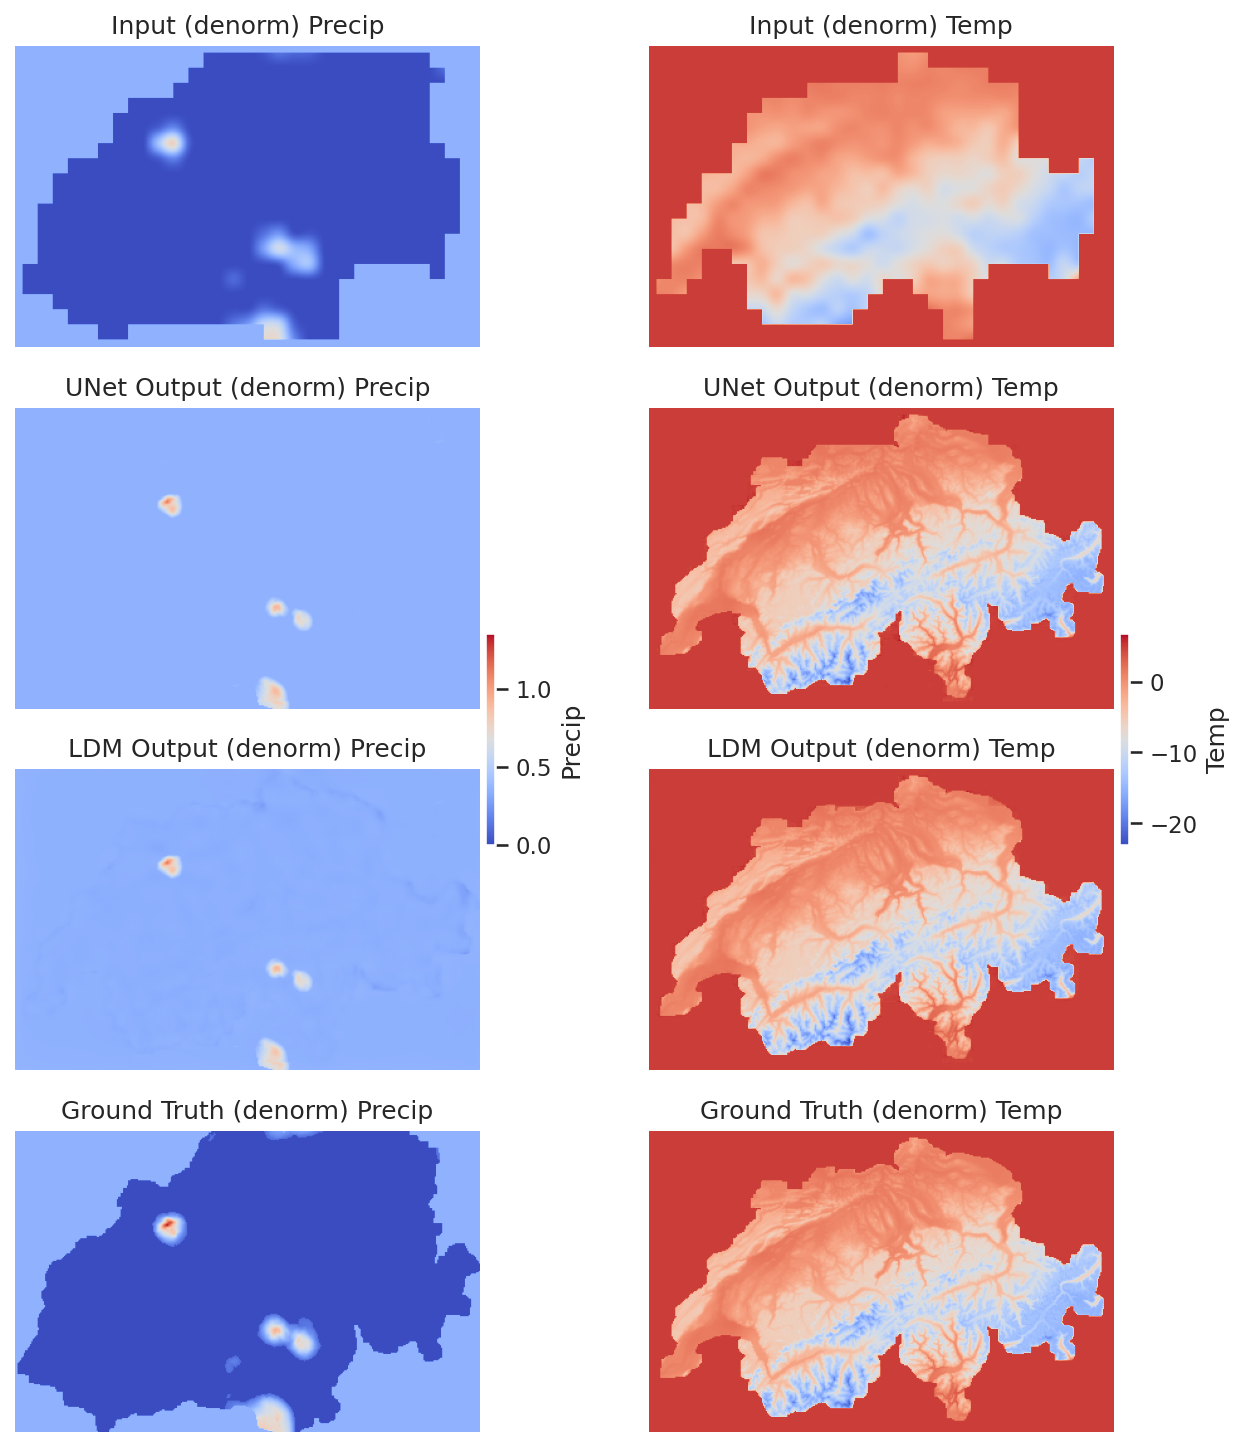

In [183]:
with torch.no_grad():
    input_sample = test_inputs[idx].unsqueeze(0).to(device)  # (1, C_in, H, W)
    unet_pred = unet_regr(input_sample)                      # (1, C_out, H, W)
    context = [(unet_pred, None)]
    sample_shape = unet_pred.shape[1:]                       # (C_out, H, W)
    z = torch.randn((1, *sample_shape), device=device)       # (1, C_out, H, W)

    # Dsampling
    residual, _ = sampler.sample(
        S=1000,
        batch_size=1,
        shape=sample_shape,
        conditioning=context,
        eta=0.0,
        verbose=False,
        x_T=z,
    )
    final_pred = unet_pred + residual

    final_pred_np = final_pred[0].cpu().numpy()              # (C_out, H, W)
    unet_pred_np = unet_pred[0].cpu().numpy()                # (C_out, H, W)
    input_np = input_sample[0, :unet_pred_np.shape[0]].cpu().numpy()  # (C_out, H, W)
    target_np = test_targets[idx][:unet_pred_np.shape[0]].cpu().numpy()  # (C_out, H, W)

    channel_names = ["Precip", "Temp"]
    params_list = [pr_params, temp_params]

    input_denorm = np.empty_like(input_np)
    for i, params in enumerate(params_list):
        input_denorm[i] = denorm_pr(input_np[i]) if i == 0 else denorm_temp(input_np[i], params)

    unet_pred_denorm = np.empty_like(unet_pred_np)
    for i, params in enumerate(params_list):
        unet_pred_denorm[i] = denorm_pr(unet_pred_np[i]) if i == 0 else denorm_temp(unet_pred_np[i], params)

    ldm_pred_denorm = np.empty_like(final_pred_np)
    for i, params in enumerate(params_list):
        ldm_pred_denorm[i] = denorm_pr(final_pred_np[i]) if i == 0 else denorm_temp(final_pred_np[i], params)

    target_denorm = np.empty_like(target_np)
    for i, params in enumerate(params_list):
        target_denorm[i] = denorm_pr(target_np[i]) if i == 0 else denorm_temp(target_np[i], params)

    # Debug: Print min/max to check for NaNs or constant arrays
    print("input_denorm", np.nanmin(input_denorm), np.nanmax(input_denorm))
    print("unet_pred_denorm", np.nanmin(unet_pred_denorm), np.nanmax(unet_pred_denorm))
    print("ddim_pred_denorm", np.nanmin(ldm_pred_denorm), np.nanmax(ldm_pred_denorm))
    print("target_denorm", np.nanmin(target_denorm), np.nanmax(target_denorm))

    vmins = [min(input_denorm[j].min(), unet_pred_denorm[j].min(), ldm_pred_denorm[j].min(), target_denorm[j].min()) for j in range(len(params_list))]
    vmaxs = [max(input_denorm[j].max(), unet_pred_denorm[j].max(), ldm_pred_denorm[j].max(), target_denorm[j].max()) for j in range(len(params_list))]

    # Plot
    fig, axes = plt.subplots(4, len(params_list), figsize=(5*len(params_list), 12), dpi=150)
    if len(params_list) == 1:
        axes = axes[:, np.newaxis]
    for j in range(len(params_list)):
        axes[0, j].imshow(np.flipud(input_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[0, j].set_title(f"Input (denorm) {channel_names[j]}")
        axes[0, j].axis('off')
        axes[1, j].imshow(np.flipud(unet_pred_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[1, j].set_title(f"UNet Output (denorm) {channel_names[j]}")
        axes[1, j].axis('off')
        axes[2, j].imshow(np.flipud(ldm_pred_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[2, j].set_title(f"LDM Output (denorm) {channel_names[j]}")
        axes[2, j].axis('off')
        axes[3, j].imshow(np.flipud(target_denorm[j]), cmap='coolwarm', vmin=vmins[j], vmax=vmaxs[j])
        axes[3, j].set_title(f"Ground Truth (denorm) {channel_names[j]}")
        axes[3, j].axis('off')
        cbar = fig.colorbar(axes[0, j].images[0], ax=axes[:, j], fraction=0.02, pad=0.01)
        cbar.ax.set_ylabel(channel_names[j])

    # Save to file in case notebook output is not working
    fig.savefig("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/DDIM_conditional_derived/outputs/debug_output.png")
    print("Plot saved as debug_output.png")

plt.show()